In [1]:
from sympy import *
import numpy as np
import matplotlib.pylab as plt
from matplotlib.colors import ListedColormap

init_printing() 

In [2]:
def cm2inch(*tupl):
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)

In [3]:
done_parsing = set()
def process(x):
    global done_parsing
    xx =  x.strip("*").strip().replace("*/","/")
    if xx[0] == "/":
        xx = "1"+xx
    if xx[-1] == "/":
        xx = xx.strip("/")
    val = sympify(xx.strip("*"))
    if val in done_parsing:
        return None
    else:
        done_parsing.add(val)
    return val

def propExt(expr,prop):
    ex = str(expr)
    open = 0
    close = 0
    diff = 0

    collect = ""
    for v in ex:
        if v in ["+","-"] and diff == 0:
            if len(collect)>0:
                d = process(collect)
                if d != None:
                    prop.append(d)
                collect = ""
                open = 0
                close = 0
        elif v == "(":
            open = open + 1
            collect = collect + v
        elif v == ")":
            close = close + 1
            collect = collect + v
        elif (v.isnumeric() or v == ".") and (diff == 0):
            if len(collect)>=3:
                if collect[-2:] == "**" or collect[-1] not in ["*","/"]:
                    collect = collect + v
            elif len(collect)>=1:
                if collect[-1] not in ["*","/"," "]:
                    collect = collect + v
            else:
                pass
        else:
            collect = collect + v	
        diff = open - close

    d = process(collect)
    if d != None:
        prop.append(d)

def termExt(expr):
    term = []
    ex = str(expr)
    open = 0
    close = 0
    diff = 0

    collect = ""
    last_sign = ""
    for v in ex:
        if v in ["+","-"] and diff == 0:
            if len(collect)>0:
                term.append(last_sign+collect)
                collect = ""
                open = 0
                close = 0
            last_sign = v
        elif v == "(":
            open = open + 1
            collect = collect + v
        elif v == ")":
            close = close + 1
            collect = collect + v
        else:
            collect = collect + v	
        diff = open - close

    term.append(last_sign+collect)
    return term

def get_prop_stoich(dxdt):
    prop = []
    dAdt = []
    for expro in dxdt:
        expr = expand(sympify(expro))
        propExt(expr,prop)
        dAdt.append(expr)

    w = prop
    V = [[0 for x in range(len(w))] for y in range(len(dAdt))]

    for i in range(len(dAdt)):
        for j in range(len(w)):
            s = 0
            for xx in termExt(dAdt[i]):
                x = sympify(xx)/w[j]
                try:
                    s = s + float(x)
                except:
                    pass
            V[i][j] = s

    return Matrix(V), Matrix(w)

def print_stoich_prop(dxdt):
    global done_parsing
    done_parsing = set()
    print()
    V, w = get_prop_stoich(dxdt)
    for t in V*w:
        print(t)
    print()

    for c in np.array(V):
        print([round(y,4) for y in c])
    print()

    for c in np.array(w):
        print(c)

def transform_to_rxn(x,dxdt):
    global done_parsing
    done_parsing = set()
    V, w = get_prop_stoich(dxdt)
    S = np.around(np.array(V).astype(float),3)
    Rxn = []
    Ksn = set()
    ind = 0 

    for col in S.T:
        R = ""
        P = ""
        for i in range(len(col)):
            if col[i] != 0:
                if col[i]<0:
                    R = R + str(abs(col[i]))+" "+x[i] +" "+ "+ "
                else:
                    P = P + str(abs(col[i]))+" "+x[i] +" "+ "+ "
        if R.strip() == "":
            R = "0 NONE"
        if P.strip() == "":
            P = "0 NONE"

        inSp = []
        for s in w[ind].free_symbols:
            ss = str(s)
            if ss in x:
                inSp.append(ss)
            else:
                Ksn.add(ss)
        inSp = ",".join(inSp)
        print(
            R.strip("+ ")+" => "+P.strip("+ ")+", 1 ::::: lambda "+inSp+" : "+str(w[ind])
        )
        ind = ind + 1

In [4]:
t = Symbol('t', real = True, nonnegative=True)
A, B = symbols('A, B', real=True, positive=True)  
k1, k2, k3, k4 = symbols('k1, k2, k3, k4',real=True,positive=True)
reactions = [k1, k2, k3, k4]
components = [A, B]

In [5]:
Stoich_mat = Matrix([
    [1, -1,  1,  0], #a
    [0,  1, -1, -1], #b
])

In [6]:
Prop_vec  = Matrix([
    k1,
    k2*A,
    k3*B,
    k4*B
]) 

In [7]:
dX_dt = Stoich_mat*Prop_vec

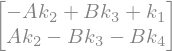

In [8]:
dX_dt

In [9]:
Aj = dX_dt.jacobian(components)

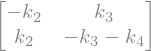

In [10]:
Aj

In [11]:
Prop_vec_F = diag(*Prop_vec )

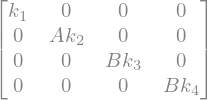

In [12]:
Prop_vec_F

In [13]:
BBT = Stoich_mat*Prop_vec_F*Stoich_mat.T

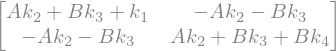

In [14]:
BBT

In [15]:
Cov = Matrix([ 
    [var("C_"+str(components[i])+str(components[j])) for j in range(len(components))] for i in range(len(components)) 
])

dsub = []
for i in range(len(components)):
    for j in range(i,len(components)):
        Cov[j,i] = Cov[i,j]
        if i != j:                        #######  Covariance set to zero
            dsub.append((Cov[j,i],0))
            Cov[i,j] = 0
            Cov[j,i] = 0

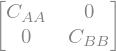

In [16]:
Cov

In [17]:
dCov_dt = Aj*Cov + Cov*Aj.T + BBT 

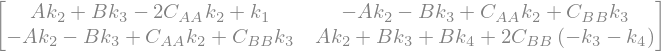

In [18]:
dCov_dt

In [19]:
Eqs_to_solve = []
ccm_components = []
ss_symbols = []

for i in range(dCov_dt.shape[0]):
    for j in range(i,dCov_dt.shape[0]):
        if Cov[i,j]!=0:
            Eqs_to_solve.append(dCov_dt[i,j].subs(dsub))
            ccm_components.append(Cov[i,j])
            ss_symbols.append(Eq(Cov[i,j].diff(t), dCov_dt[i,j].subs(dsub)))
        
for i in range(dX_dt.shape[0]):
    Eqs_to_solve.append(dX_dt[i])
    ccm_components.append(components[i])
    ss_symbols.append(Eq(components[i].diff(t), dX_dt[i]))

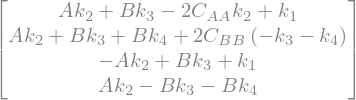

In [20]:
Matrix([Eqs_to_solve]).T

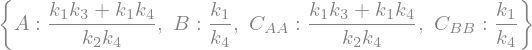

In [21]:
simplify(solve(ss_symbols,ccm_components))

In [22]:
zz_Prop_vec = Matrix([ Eqs_to_solve[i] for i in range(len(Eqs_to_solve))])

In [23]:
ccm_components = Matrix(ccm_components)

In [24]:
ss_components = [ str(ccm_components[i,0]) for i in range(ccm_components.shape[0]) ]

In [25]:
zz_Prop_vec = [ x for x in zz_Prop_vec if x!=0]

In [26]:
transform_to_rxn(ss_components, zz_Prop_vec)

1.0 A => 1.0 C_AA + 1.0 C_BB + 1.0 B, 1 ::::: lambda A : A*k2
1.0 B => 1.0 C_AA + 1.0 C_BB + 1.0 A, 1 ::::: lambda B : B*k3
2.0 C_AA => 0 NONE, 1 ::::: lambda C_AA : C_AA*k2
0 NONE => 1.0 C_AA + 1.0 A, 1 ::::: lambda  : k1
1.0 B => 1.0 C_BB, 1 ::::: lambda B : B*k4
2.0 C_BB => 0 NONE, 1 ::::: lambda C_BB : C_BB*k3
2.0 C_BB => 0 NONE, 1 ::::: lambda C_BB : C_BB*k4


In [27]:
done_parsing = set()
Sp_stoich, fp_Prop = get_prop_stoich(zz_Prop_vec)

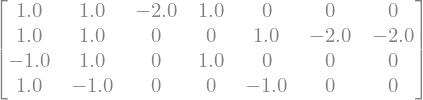

In [28]:
Sp_stoich

In [29]:
fp_Prop.T

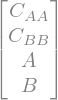

In [30]:
ccm_components

In [31]:
fp_Prop = Matrix([ eval(str(x)) for x in fp_Prop ])

In [32]:
kerV = Matrix(Sp_stoich.nullspace(0))

In [33]:
kerV.shape

In [34]:
kerV = kerV.reshape(int(len(kerV)/len(fp_Prop)),len(fp_Prop))

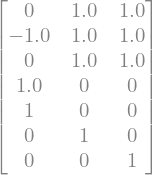

In [35]:
kerV.T

In [36]:
Sp_stoich*kerV[0,:].T

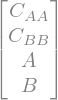

In [37]:
ccm_components

In [38]:
Aj = fp_Prop.jacobian(ccm_components)

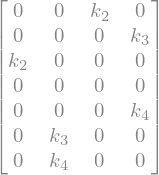

In [39]:
Aj

In [40]:
Aj = Aj.col_insert(Aj.shape[1],-kerV.T)

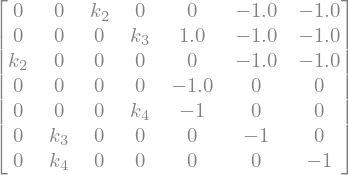

In [41]:
Aj

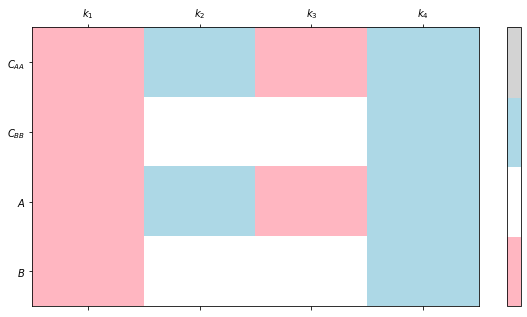

In [42]:
Jfp = fp_Prop.jacobian(reactions).T

Sprime = simplify(Aj.inv())
Nans = Matrix(Sprime)

ans = Matrix([])
for i in range(len(reactions)):
    col = None
    for j in range(Jfp.shape[1]):
        if Jfp[i,j] != 0:
            if col is None:
                col = simplify(Nans[:,j])
            else:
                col = col + simplify(Nans[:,j])
    ans = ans.col_insert(ans.shape[1],col)

for i in range(ans.shape[0]):
    for j in range(ans.shape[1]):
        v = ans[i,j]
        try:
            if ans[i,j]>0:
                ans[i,j] = 1
            elif ans[i,j]<0:
                ans[i,j] = -1
            elif ans[i,j] == 0:
                ans[i,j] = 0
        except:
            ans[i,j] = 2      
            
col = []
for i in range(ans.shape[0]):
    try:
        col.append("$"+str(ccm_components[i]).replace("_","_{")+"}"+"$")
    except:
        pass
    
label_list = [ "$"+str(x).replace("k","k_{")+"}"+"$" for x in reactions ]
    
plt.figure(figsize=(10,5))
plt.matshow(np.array(ans[0:len(col),:],dtype=float),fignum=1,interpolation=None,vmin=-1,aspect="auto",vmax=2,cmap=ListedColormap(['lightpink', 'white','lightblue','lightgrey']))
plt.xticks(ticks=range(len(reactions)),labels=label_list)
plt.yticks(ticks=range(len(col)),labels=col)
plt.colorbar(ticks=[])
plt.show()
plt.close()

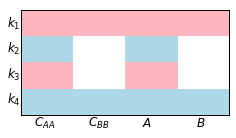

In [60]:
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['mathtext.rm'] = 'Arial'
plt.rcParams['font.family'] = "DejaVu Sans"

plt.figure(figsize=cm2inch(9.5,4.75))
data = np.array(ans[0:len(col),:],dtype=float)
plt.matshow(
    data.T,
    fignum=1,
    aspect="auto",
    interpolation=None,vmin=-1, vmax=2,
    cmap=ListedColormap(['lightpink', 'white','lightblue','lightgrey'])
)

#plt.xticks(ticks=range(len(reactions)),labels=label_list)
plt.yticks(ticks=range(len(col)),labels=col)

plt.xticks([])
plt.yticks([])

for i in range(4):
    #plt.figtext(0.07,0.18*i+0.17, col[3-i])
    #plt.figtext(0.2*i+0.2,-0.00, label_list[i])
    plt.figtext(0.1,0.19*i+0.17, label_list[3-i])
    plt.figtext(0.2*i+0.2,-0.00, col[i])
#plt.colorbar(ticks=[])
plt.savefig("Figure_3A.png",dpi=600,bbox_inches='tight',transparent=False,pad_inches = 0.01)